<a href="https://colab.research.google.com/github/cuixianze/reinforce-learning/blob/main/khunpoker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install --upgrade open_spiel

In [2]:
import pyspiel
import numpy as np

# Kuhn Poker 환경 로드
game = pyspiel.load_game("kuhn_poker")

# 테스트용 게임 초기화 및 상태 출력
state = game.new_initial_state()
print("초기 상태:", state)
while not state.is_terminal():

  action = np.random.choice(state.legal_actions())


  print("가능액션", state.legal_actions(), "실제 액션,",action)
  state.apply_action(action)
  print(str(state) + '\n')


print(state.history())
print(state.rewards())

초기 상태: 
가능액션 [0, 1, 2] 실제 액션, 0
0

가능액션 [1, 2] 실제 액션, 1
0 1

가능액션 [0, 1] 실제 액션, 0
0 1 p

가능액션 [0, 1] 실제 액션, 0
0 1 pp

[0, 1, 0, 0]
[-1.0, 1.0]


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import pyspiel
from collections import deque

# 기본 DQN 네트워크
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# 경험 리플레이 저장소
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)

# Q-learning 업데이트 함수
def update_dqn(network, target_network, memory, batch_size, gamma, optimizer):
    if memory.size() < batch_size:
        return

    experiences = memory.sample(batch_size)

    states, actions, rewards, next_states, done = zip(*experiences)

    states = torch.tensor(states, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    done = torch.tensor(done, dtype=torch.bool)

    current_q_values = network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = target_network(next_states).max(1)[0]

    target_q_values = rewards + (gamma * next_q_values * ~done)

    loss = nn.MSELoss()(current_q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Q-values 시각화 함수
def plot_q_values(network, player_id, title_suffix=""):
    state_examples = []

    # 카드 분배 후 가능한 상태 생성
    for my_card in range(3):  # 카드 0,1,2
        for opponent_card in range(3):
            if my_card == opponent_card:
                continue
            for history in ["", "p", "b", "pb", "bp", "bb", "pp"]:
                state = game.new_initial_state()
                state.apply_action(my_card)
                state.apply_action(opponent_card)
                for h in history:
                    if h == "p":
                        state.apply_action(0)
                    elif h == "b":
                        state.apply_action(1)
                if not state.is_terminal() and state.current_player() == player_id:
                    state_examples.append(state)

    q_values_list = []
    labels = []

    # 각 상태에 대해 Q-values 추출
    for state in state_examples:
        obs_tensor = torch.tensor(state.observation_tensor(player_id), dtype=torch.float32)
        q_values = network(obs_tensor).detach().numpy()
        q_values_list.append(q_values)
        state_obs = state.observation_tensor(player_id)
        # 상태를 "카드 + 행동" 형태로 간단히 표현
        if state_obs[2] == 1:
            card_info = "Card 0"
        elif state_obs[3] == 1:
            card_info = "Card 1"
        elif state_obs[4] == 1:
            card_info = "Card 2"

        if state_obs[5] == 1 and state_obs[6] == 1:
            action_info = "pp of nothing"
        elif state_obs[5] == 2 and state_obs[6] == 1:
            action_info = "b"
        elif state_obs[5] == 1 and state_obs[6] == 2:
            action_info = "pb"
        labels.append(f"{card_info} {action_info}")

    q_values_array = np.array(q_values_list)

    # 그래프 그리기
    plt.figure(figsize=(12, 6))
    for action in range(q_values_array.shape[1]):
        plt.plot(q_values_array[:, action], label=f"Action {action}")

    # X축을 카드와 행동 정보로 변경
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
    plt.xlabel("Card and Action")
    plt.ylabel("Q-value")
    plt.title(f"Q-values for Player {player_id} {title_suffix}")
    plt.legend()
    plt.tight_layout()
    plt.show()

----new game----
P1_state [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
2 1 b

P1_state [1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
2 1 bb

Episode 0 completed. Player 0 Total Reward: 2.0, Player 1 Total Reward: -2.0


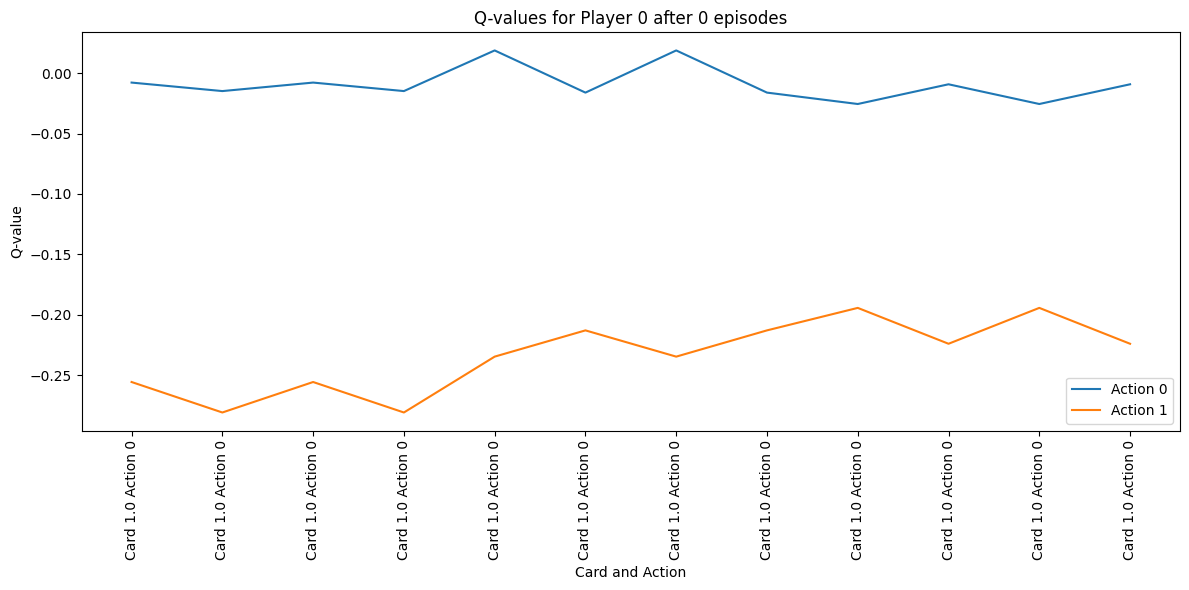

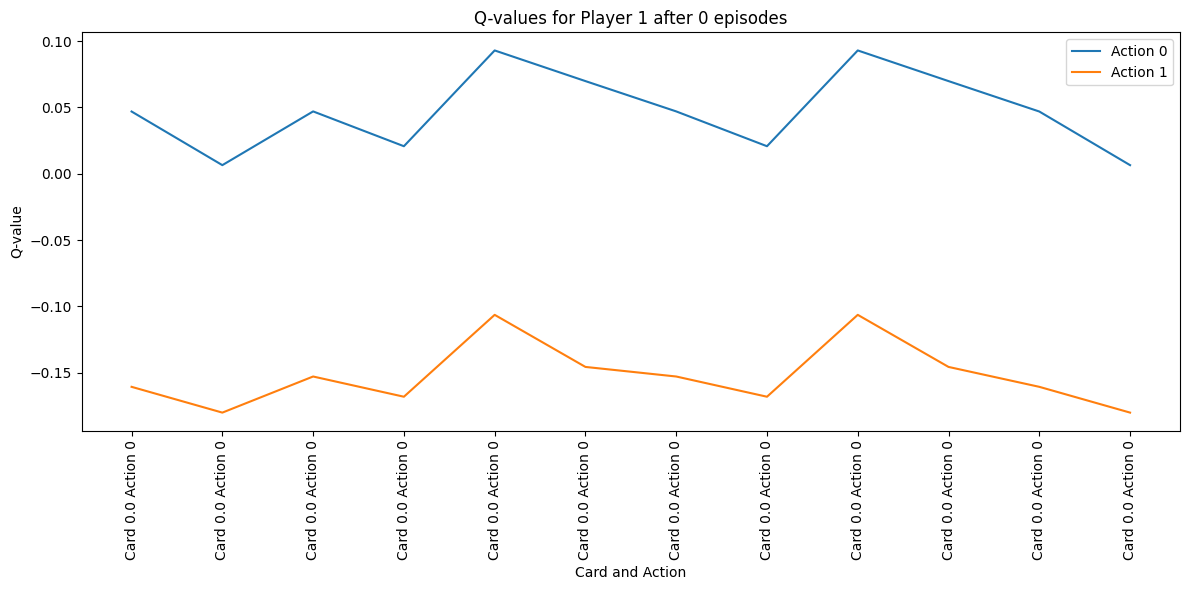

----new game----
P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 2 p

P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 2 pp

----new game----
P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 2 p

P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 2 pp

----new game----
P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 1 p

P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 1 pp

----new game----
P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
1 2 p

P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실

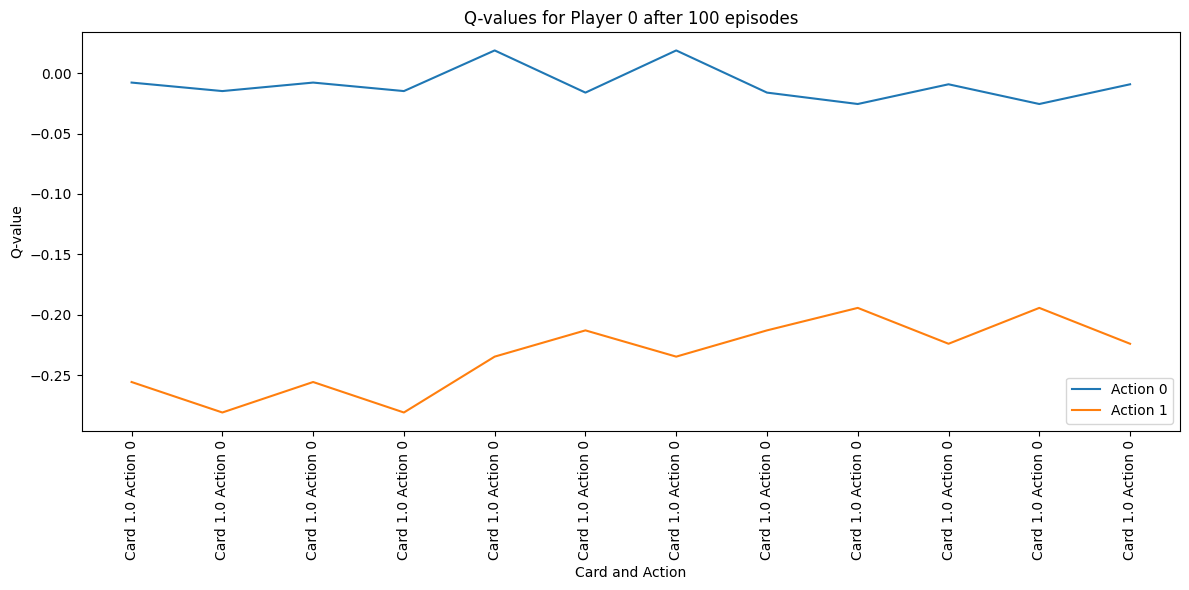

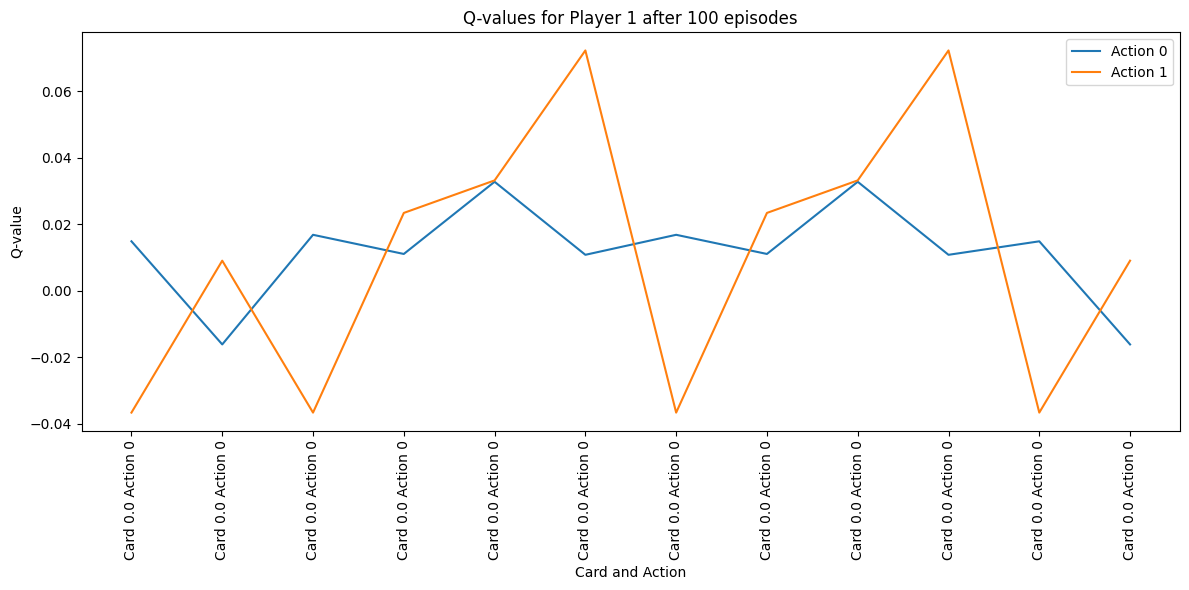

----new game----
P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 1 p

P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 1 pp

----new game----
P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 2 p

P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 2 pp

----new game----
P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 1 p

P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 1 pp

----new game----
P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 2 p

P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실

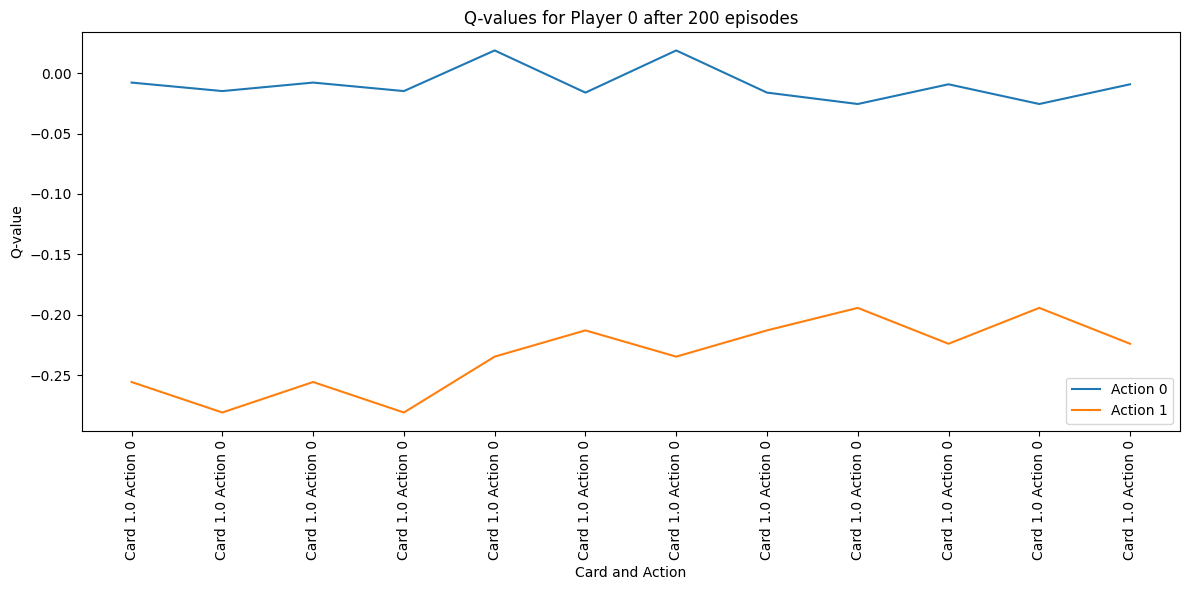

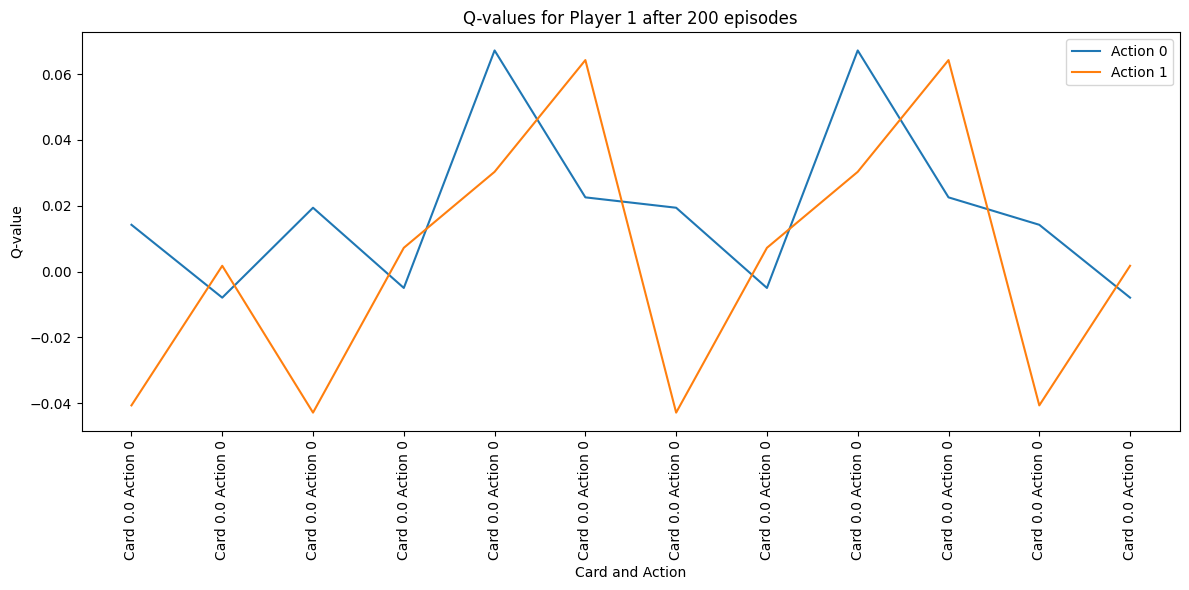

----new game----
P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
1 2 p

P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
1 2 pp

----new game----
P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 1 p

P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 1 pp

----new game----
P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 1 p

P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 1 pp

----new game----
P1_state [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
P2_state [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
2 0 p

P1_state [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
P2_state [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실

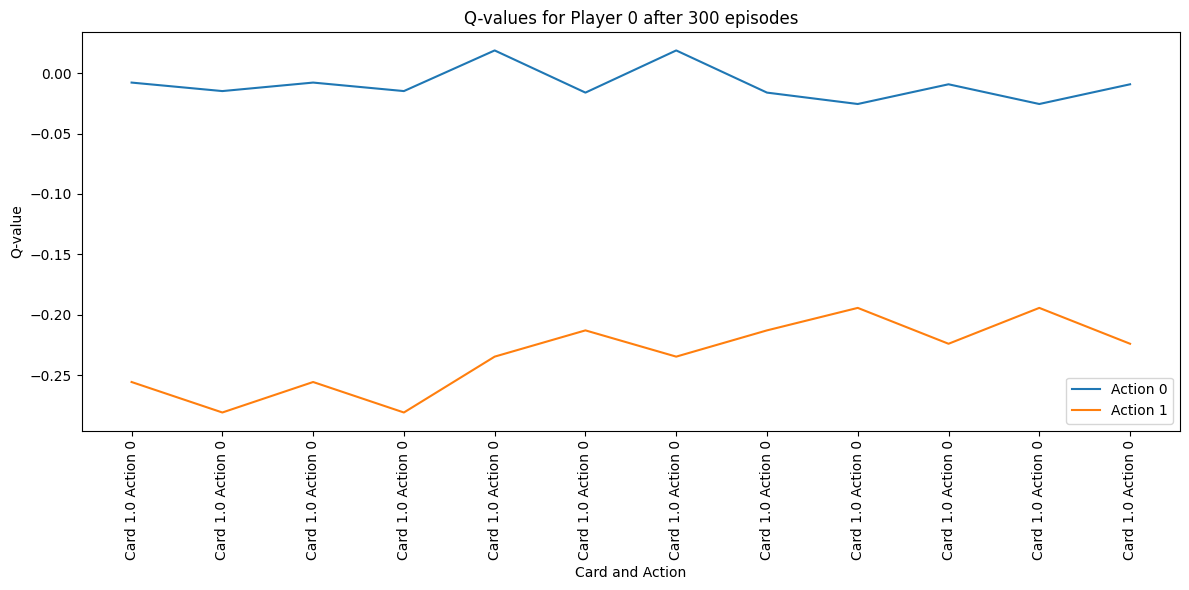

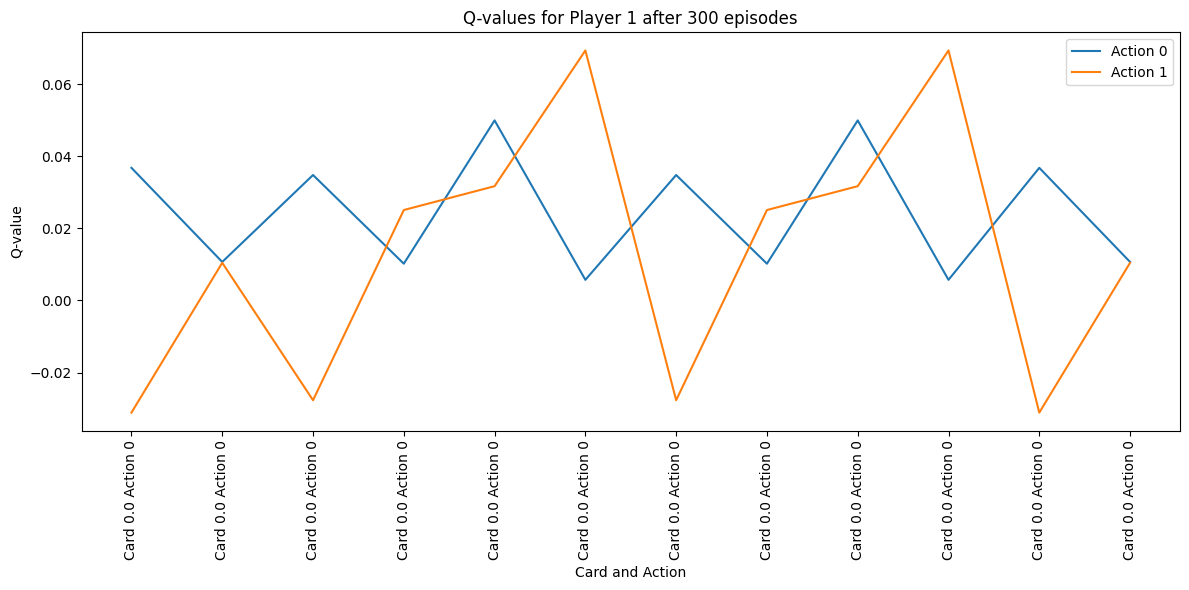

----new game----
P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
1 0 p

P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
1 0 pp

----new game----
P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
1 0 p

P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
1 0 pp

----new game----
P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 2 p

P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 2 pp

----new game----
P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 2 p

P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실

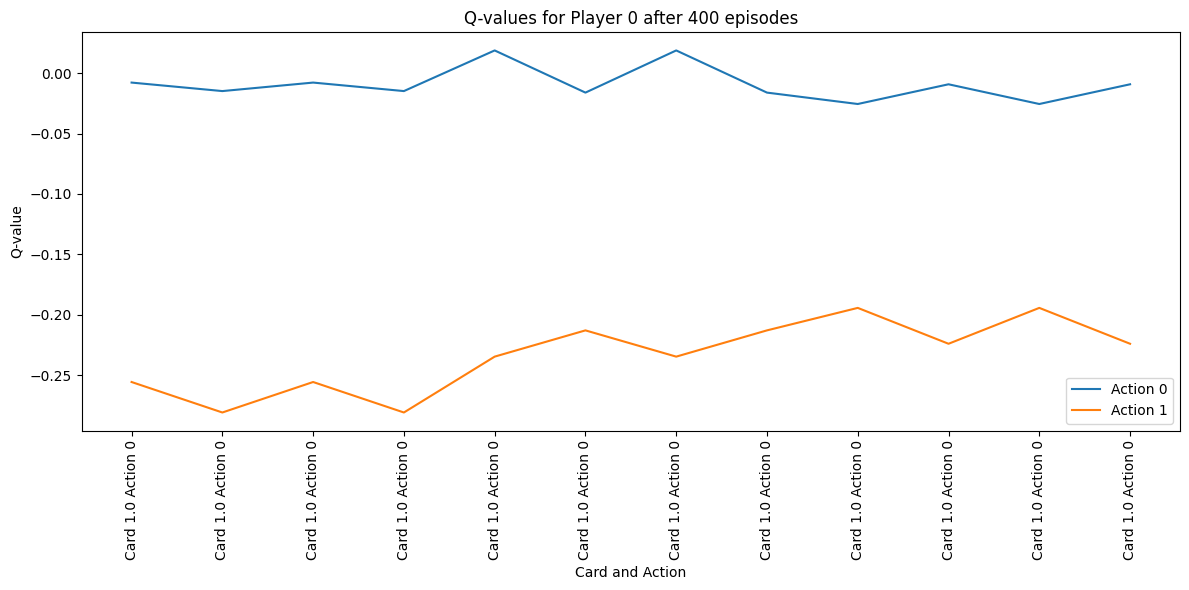

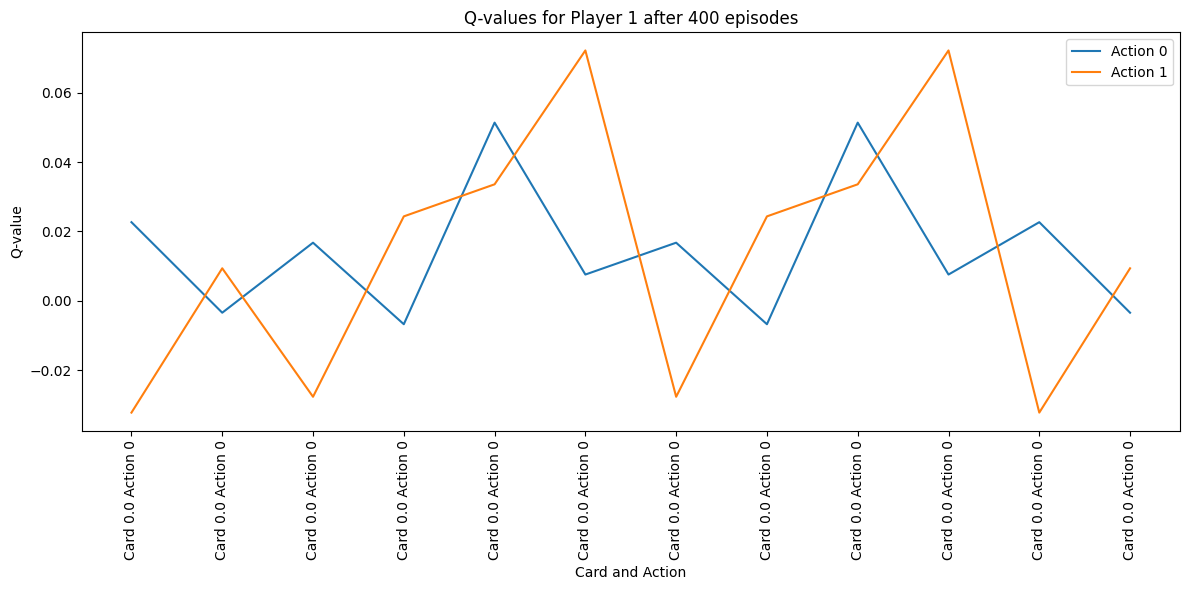

----new game----
P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
1 2 b

P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
1 2 bb

----new game----
P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
1 2 b

P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
1 2 bb

----new game----
P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
1 0 b

P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0]
P2_state [0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
1 0 bb

----new game----
P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
1 2 b

P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0]
가능액션 [0, 1] 실

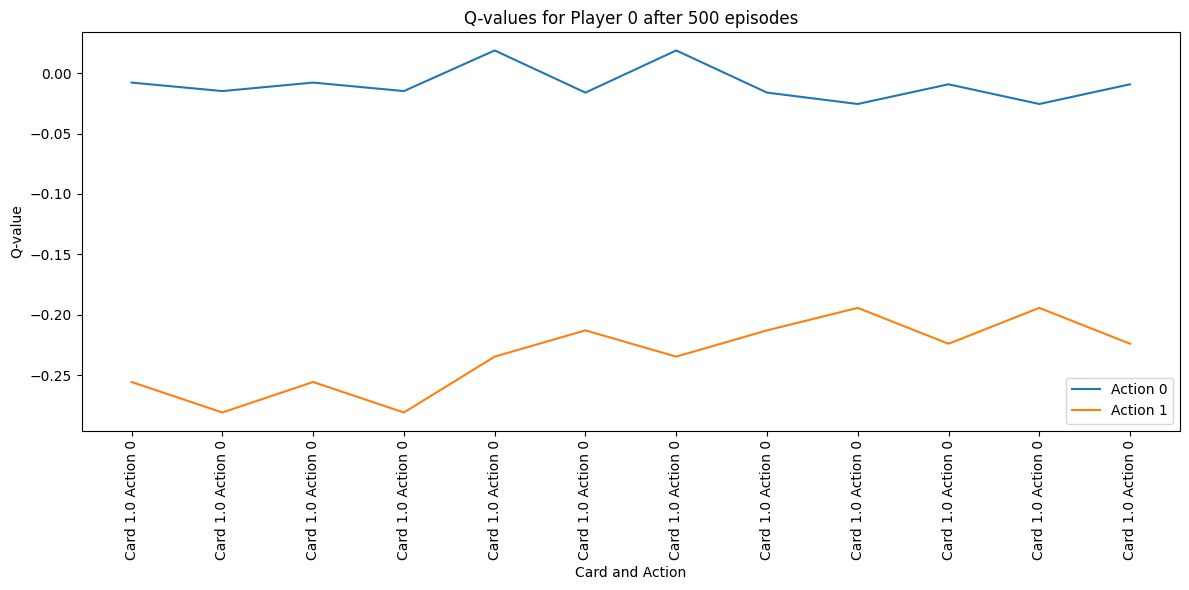

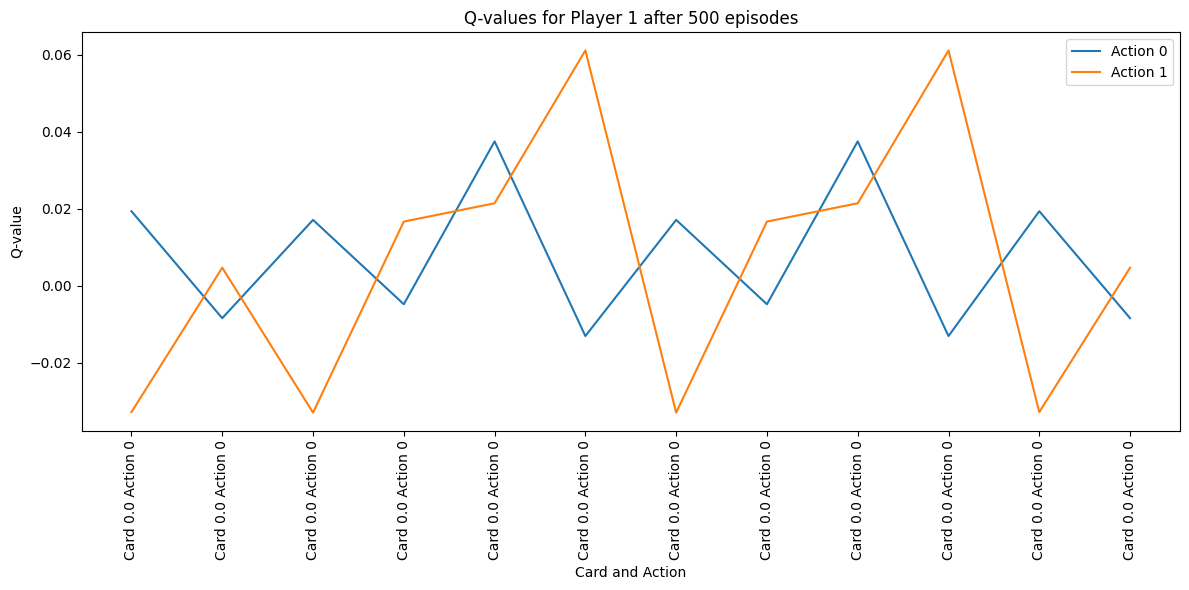

----new game----
P1_state [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
2 1 b

P1_state [1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
2 1 bb

----new game----
P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
0 2 b

P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
0 2 bb

----new game----
P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
1 2 b

P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
1 2 bb

----new game----
P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
0 1 b

P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0]
가능액션 [0, 1] 실

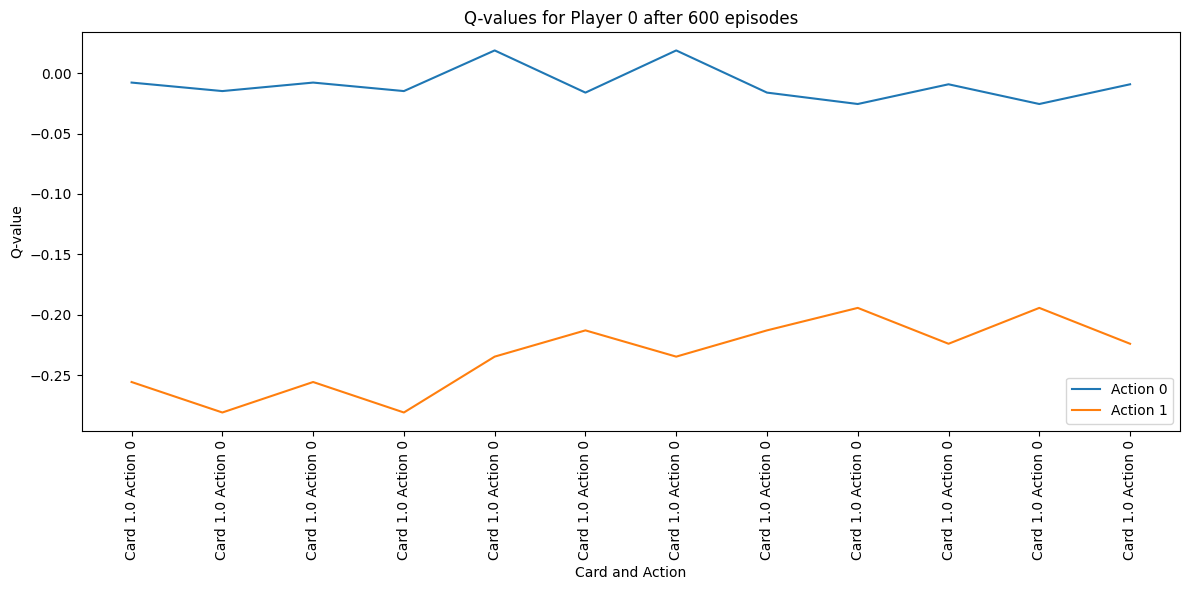

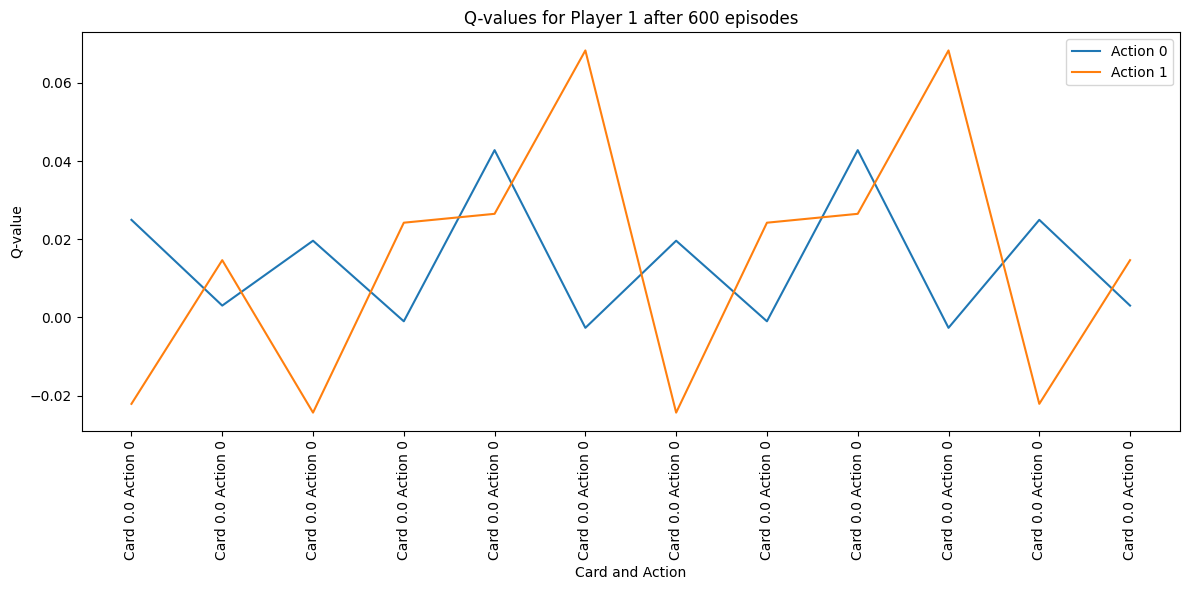

----new game----
P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
1 2 p

P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
1 2 pp

----new game----
P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
1 2 p

P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
1 2 pp

----new game----
P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
1 2 p

P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
1 2 pp

----new game----
P1_state [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
2 1 p

P1_state [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실

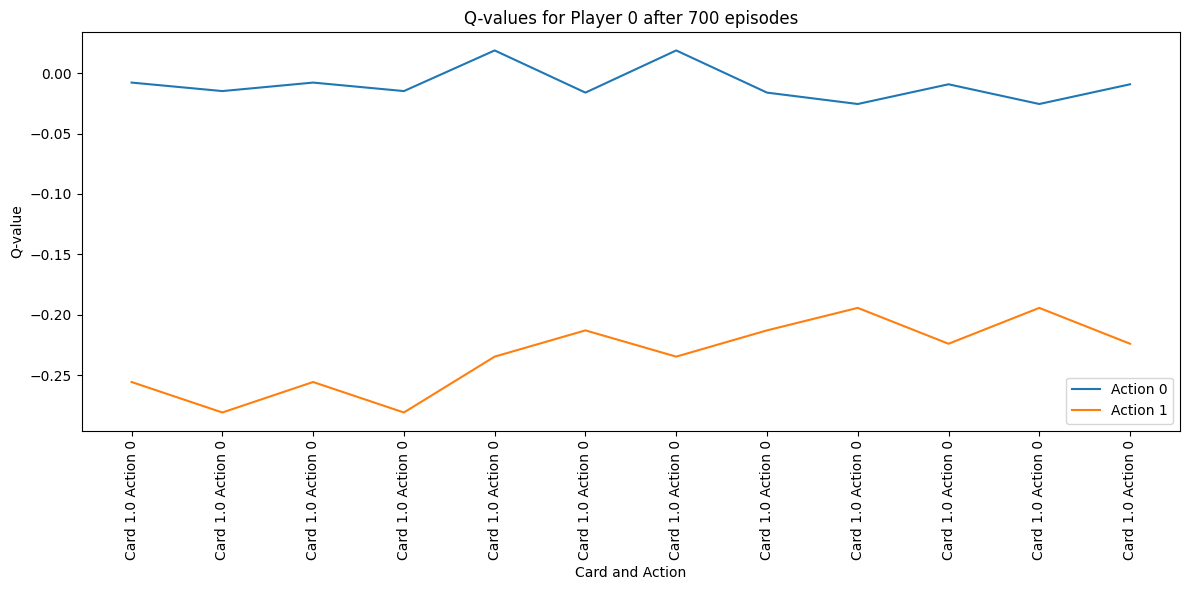

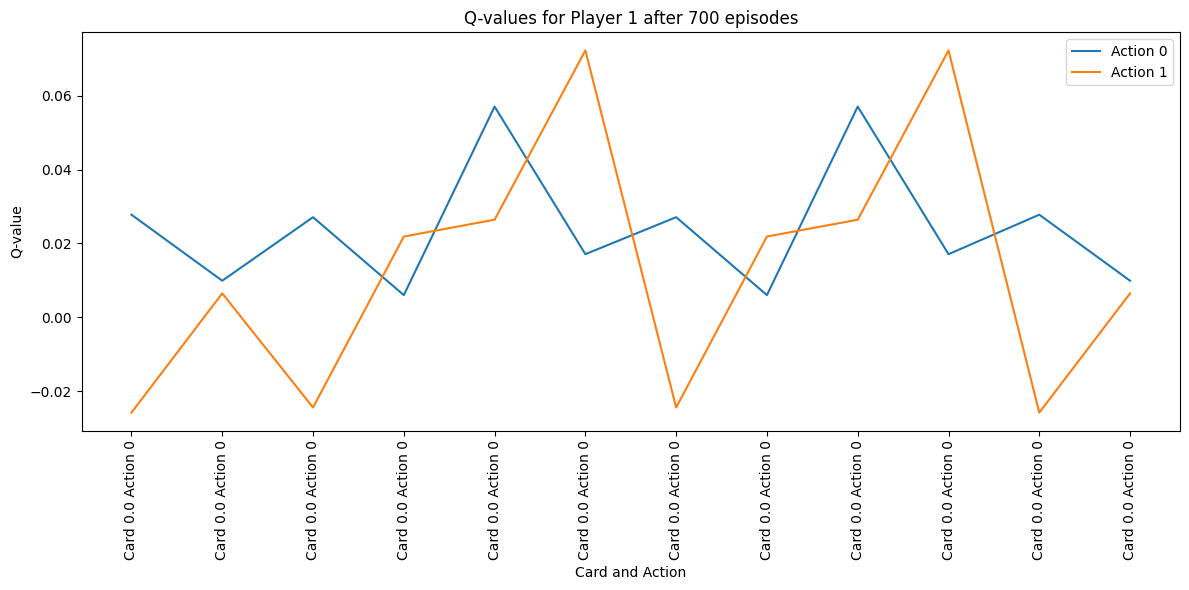

----new game----
P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
0 2 b

P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
0 2 bb

----new game----
P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
1 2 b

P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
1 2 bb

----new game----
P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
0 2 b

P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
0 2 bb

----new game----
P1_state [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
2 1 b

P1_state [1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0]
가능액션 [0, 1] 실

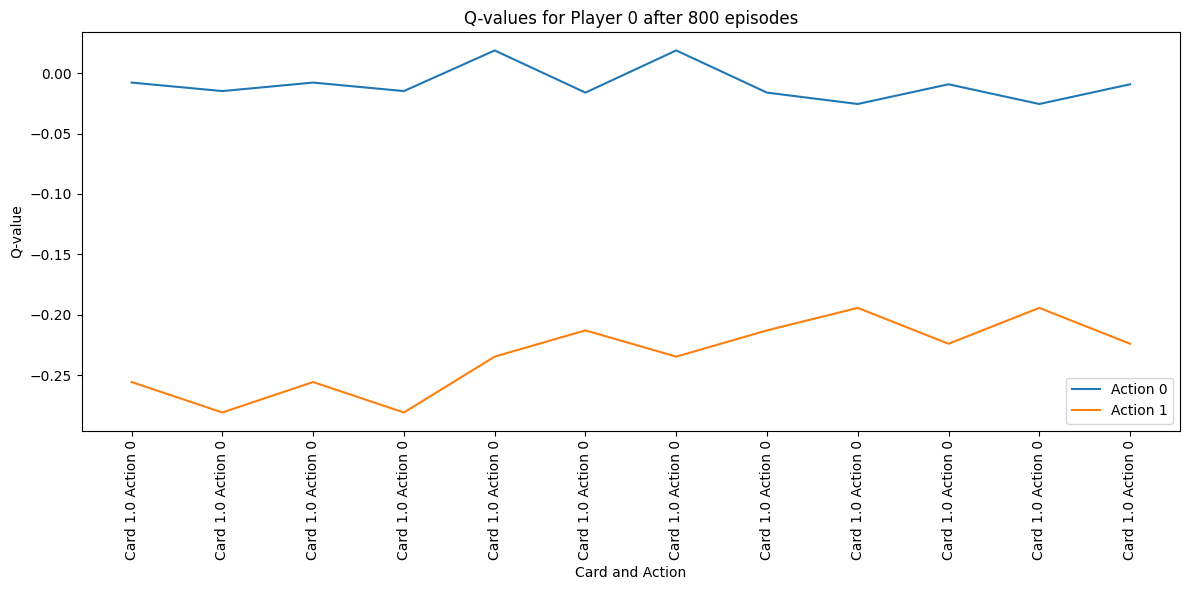

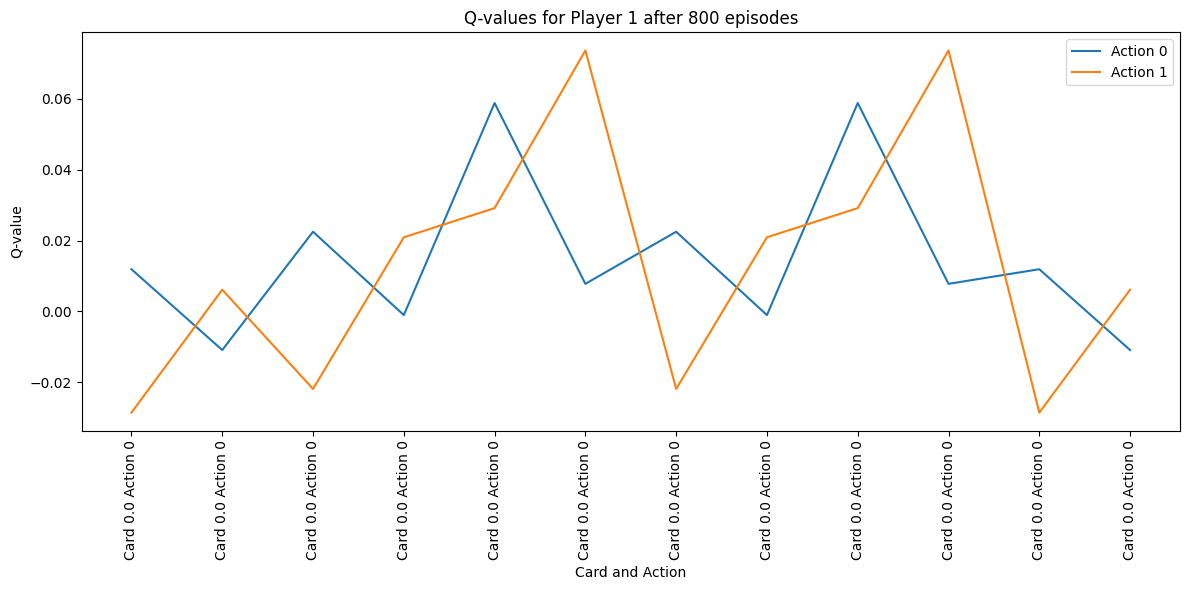

----new game----
P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 1 p

P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 1 pp

----new game----
P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
1 0 p

P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
1 0 pp

----new game----
P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
1 0 p

P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
1 0 pp

----new game----
P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 1
1 0 b

P1_state [1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0]
P2_state [0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0]
가능액션 [0, 1] 실

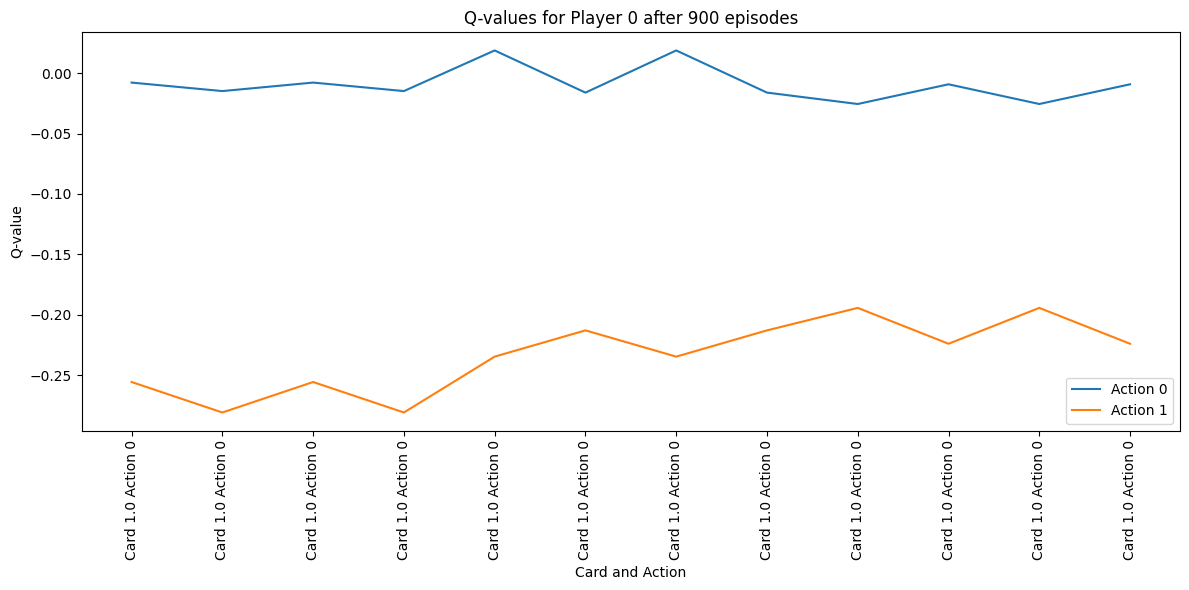

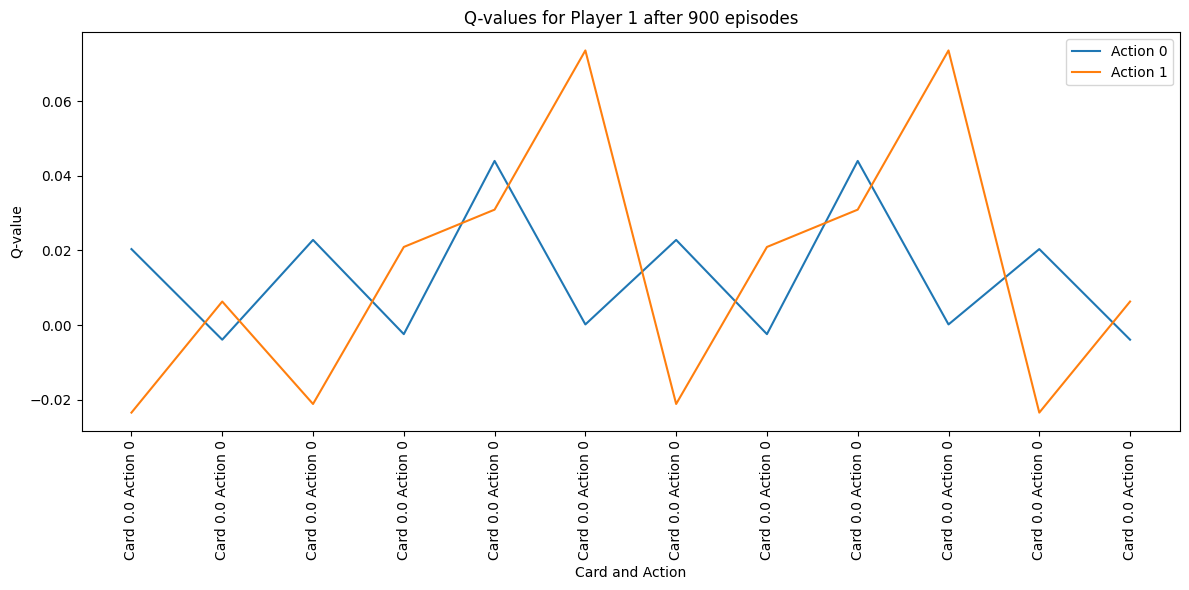

----new game----
P1_state [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
P2_state [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
2 0 p

P1_state [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
P2_state [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
2 0 pp

----new game----
P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 2 p

P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 2 pp

----new game----
P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 1 p

P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 1 pp

----new game----
P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실제 액션, 0
0 1 p

P1_state [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
P2_state [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
가능액션 [0, 1] 실

In [15]:

# 게임 환경과 학습 설정
game = pyspiel.load_game("kuhn_poker")
state_size = 7  # 간단한 예로 상태 크기를 3으로 가정
action_size = 2  # Kuhn Poker에서 가능한 액션: 0, 1, 2
gamma = 0.99
batch_size = 32
lr = 1e-3
epsilon = 0.1
memory_capacity = 10000
target_update_frequency = 1000

# 두 플레이어의 DQN 네트워크 초기화
player_0_network = DQN(state_size, action_size)
player_1_network = DQN(state_size, action_size)

# 두 플레이어의 타겟 네트워크 초기화
player_0_target_network = DQN(state_size, action_size)
player_1_target_network = DQN(state_size, action_size)

# 옵티마이저
player_0_optimizer = optim.Adam(player_0_network.parameters(), lr=lr)
player_1_optimizer = optim.Adam(player_1_network.parameters(), lr=lr)

# 경험 리플레이 버퍼
player_0_memory = ReplayBuffer(memory_capacity)
player_1_memory = ReplayBuffer(memory_capacity)

# 학습 루프
for episode in range(1000):  # 학습을 1000 에피소드로 설정
    print("----new game----")
    state = game.new_initial_state()
    done = False

    # 각 플레이어의 누적 리워드
    total_reward_player_0 = 0  # Player 0의 총 보상
    total_reward_player_1 = 0  # Player 1의 총 보상

    cards = [0,1,2]
    p1_card = np.random.choice(cards)
    cards.remove(p1_card)
    p2_card = np.random.choice(cards)

    state.apply_action(p1_card)
    state.apply_action(p2_card)


    while not state.is_terminal():
        # 각 플레이어의 행동 선택
        print("P1_state", state.observation_tensor(0))
        print("P2_state", state.observation_tensor(1))

        current_player = state.current_player()
        obs_tensor = state.observation_tensor(current_player)
        obs_tensor_tensor = torch.tensor(obs_tensor, dtype=torch.float32)

        # ε-greedy 정책을 사용한 액션 선택
        if np.random.rand() < epsilon:
            action = np.random.choice(state.legal_actions())
        else:
            if current_player == 0:
                q_values = player_0_network(obs_tensor_tensor).detach().numpy()
            else:
                q_values = player_1_network(obs_tensor_tensor).detach().numpy()

        print("가능액션", state.legal_actions(), "실제 액션,",action)
        # 행동 적용
        state.apply_action(action)
        print(str(state) + '\n')

        # 상태 및 보상 추출
        if state.is_terminal():
            rewards = state.rewards()
            total_reward_player_0 += rewards[0]
            total_reward_player_1 += rewards[1]
            done = True
        else:
            reward = 0  # 게임이 종료되지 않았다면 보상은 0

        # 경험 리플레이에 추가
        if state.current_player() == 0:
            player_0_memory.push((state.observation_tensor(0), action, reward, state.observation_tensor(0), done))
        else:
            player_1_memory.push((state.observation_tensor(1), action, reward, state.observation_tensor(1), done))

        # Q-learning 업데이트
        update_dqn(player_0_network, player_0_target_network, player_0_memory, batch_size, gamma, player_0_optimizer)
        update_dqn(player_1_network, player_1_target_network, player_1_memory, batch_size, gamma, player_1_optimizer)


    # 타겟 네트워크 업데이트 주기
    if episode % target_update_frequency == 0:
        player_0_target_network.load_state_dict(player_0_network.state_dict())
        player_1_target_network.load_state_dict(player_1_network.state_dict())

    # 주기적인 로그 출력 (에피소드, 플레이어의 누적 리워드)
    if episode % 100 == 0:
        print(f"Episode {episode} completed. Player 0 Total Reward: {total_reward_player_0}, Player 1 Total Reward: {total_reward_player_1}")
        plot_q_values(player_0_network, player_id=0, title_suffix=f"after {episode} episodes")
        plot_q_values(player_1_network, player_id=1, title_suffix=f"after {episode} episodes")


In [53]:
# 상태 차원 확인 (디버깅용)
state = game.new_initial_state()
print(state.observation_tensor(0))  # 플레이어 0의 상태 출력
print(state.observation_tensor(1))  # 플레이어 1의 상태 출력


[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]
